In [14]:
import sys
!{sys.executable} -m pip install sklearn

     |████████████████████████████████| 7.3 MB 558 kB/s eta 0:00:01
     |████████████████████████████████| 30.9 MB 44.0 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 37.1 MB/s eta 0:00:01
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done


In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [31]:
start = datetime(2019, 1, 1)
end = datetime.now()
df = yf.download('MSFT', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [17]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.189774,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.399292,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,211.762268,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,217.788391,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.115341,22956200


In [18]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,87.000000,87.000000,87.000000,87.000000,87.000000,8.700000e+01
mean,238.488161,240.862185,236.363218,238.721839,238.539959,2.943006e+07
std,13.097862,12.780935,13.235913,13.164126,13.285938,8.773674e+06
min,212.169998,214.509995,211.940002,212.250000,211.762268,1.575110e+07
25%,231.449997,234.184998,229.175003,231.725006,231.513496,2.340715e+07
50%,237.009995,240.059998,234.309998,237.130005,237.130005,2.701010e+07
75%,247.709999,249.910004,245.790001,248.465004,248.465004,3.323315e+07
max,261.660004,263.190002,260.170013,261.970001,261.970001,6.987060e+07


<AxesSubplot:xlabel='Date'>

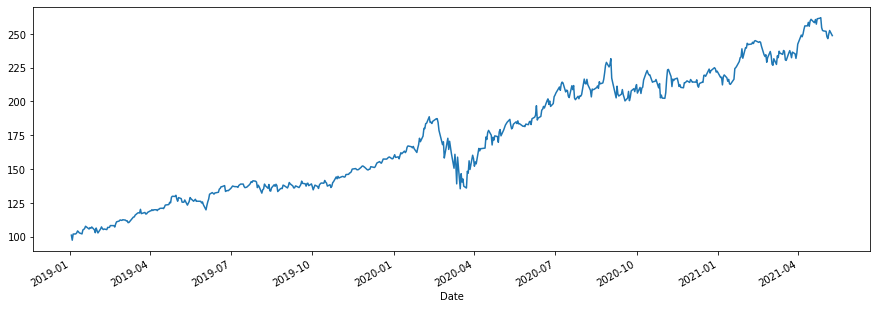

In [32]:
plt.figure(figsize=(15, 5))
df['Close'].plot()

In [33]:
#Adding predictions column
df['prediction'] = df['Close'].shift(-1)
df.dropna(inplace=True)

In [34]:
#Number of days to forecast for
forecast_time = int(30)

In [35]:
#Scaling the data between 0 and 1
X_unscaled = df.drop(['prediction'], 1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_unscaled)

In [36]:
#Defining X and target Y
X = X_scaled
Y = df['prediction']

In [37]:
#Splitting the data keeping the test size equalt to forecasted days
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=forecast_time, random_state=0)
X_prediction = X[-forecast_time:]
Y_test = Y[-forecast_time:]

In [38]:
# Performing regression on the training data
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [39]:
#Trying to predict the data
prediction = regressor.predict(X_prediction)

In [40]:
print('RMSE score: ', np.sqrt(metrics.mean_squared_error(Y_test, prediction)))
r2 = metrics.r2_score(Y_test, prediction, sample_weight=None, multioutput='uniform_average')
print('R-squared score: ', r2)
adjusted_r_squared = 1 - (1-r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print('Adjusted R-squared: ', adjusted_r_squared)

RMSE score:  1.5506138098222426
R-squared score:  0.9604104365668277
Adjusted R-squared:  0.9600043897623849


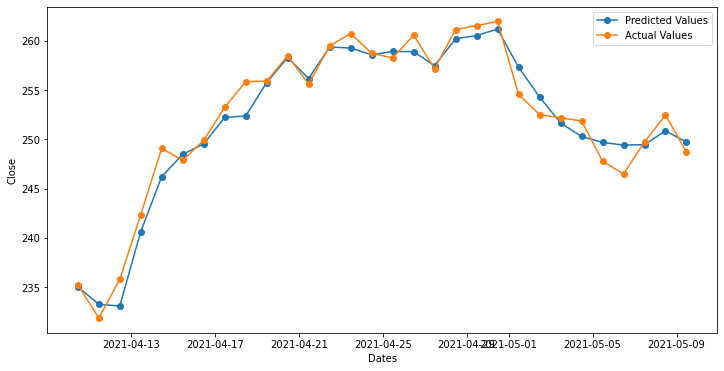

In [41]:
#Plotting the graph of actual vs predicted
plt.figure(figsize=(12, 6))
plt.xlabel('Dates')
plt.ylabel('Close')

sdate = datetime.now() - timedelta(days=forecast_time)
edate = datetime.now() - timedelta(days=forecast_time) + timedelta(days=forecast_time-1)
delta = edate - sdate
datesArray = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    datesArray.append(day)

plt.plot(datesArray, prediction, '-o')
plt.plot(datesArray, Y_test, '-o')
plt.legend(["Predicted Values", "Actual Values"])
plt.show()

In [48]:
#Defining a function to determine whether to buy or sell
def buy_or_sell(historical_close_avg, next_day_prediction):
    mean_of_historical_close_avg = historical_close_avg.mean()
    if next_day_prediction > mean_of_historical_close_avg:
        return 'buy'
    elif next_day_prediction < mean_of_historical_close_avg:
        return 'sell'
    else:
        return 'hold'

In [49]:
#The decision will be made based on average of last 3 days
size = 3
correct = wrong = total = 0

In [50]:
#Determining whether the predictions are right or wrong
for t in range(len(Y_test)):
    yhat = prediction[t]
    obs = Y_test[t]
    status = buy_or_sell(df.Close[len(df.Close[0:size])-t-size: len(df.Close[0:size])-t], yhat)
    print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(Y_test.index[t-size].date()), status))
    real = buy_or_sell(df.Close[len(df.Close[0:size])-t-size: len(df.Close[0:size])-t], Y_test[t-size])
    if status != real:
        wrong += 1
    else:
        correct += 1
    total += 1
print("Correct predictions:", correct)
print("Wrong predictions:", wrong)

Prediction: Tomorrow (utc:2021-05-05) it is more favourable to buy
Prediction: Tomorrow (utc:2021-05-06) it is more favourable to hold
Prediction: Tomorrow (utc:2021-05-07) it is more favourable to hold
Prediction: Tomorrow (utc:2021-03-26) it is more favourable to hold
Prediction: Tomorrow (utc:2021-03-29) it is more favourable to sell
Prediction: Tomorrow (utc:2021-03-30) it is more favourable to sell
Prediction: Tomorrow (utc:2021-03-31) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-01) it is more favourable to buy
Prediction: Tomorrow (utc:2021-04-05) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-06) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-07) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-08) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-09) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-12) it is more favourable to sell
Prediction: Tomorrow (utc:2021-04-13) it is more f

In [52]:
#Calculating accuracy
accuracy = correct/total * 100
print("Accuracy: ", accuracy)

Accuracy:  76.66666666666667
